# Задание 1

Модифицируйте EM-алгоритм таким образом, чтобы он находил не два, а три кластера на наших данных.

# Решение задания 1

Импорт необходимых библиотек

In [ ]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score

Скачивание датасета с гугл-диска

In [ ]:
!gdown --id 17mf6RUEFOJ19t2zNuFlswSUs7MODwLlk

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=17mf6RUEFOJ19t2zNuFlswSUs7MODwLlk
To: /content/EM_dataset.csv
100% 12.6k/12.6k [00:00<00:00, 12.7MB/s]


Визуализация данных датасета с помощью диаграммы рассеяния (т.е. с помощью scatterplot)



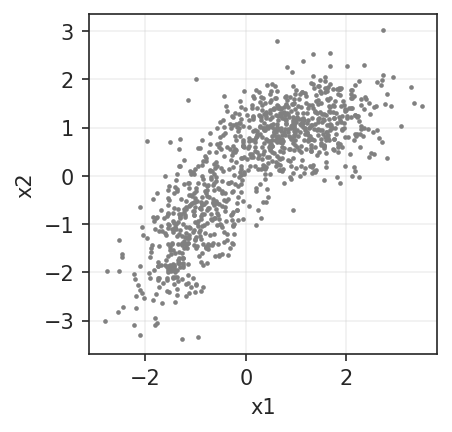

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style("ticks")
df = pd.read_csv("EM_dataset.csv")
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
sns.scatterplot(x="x1", y="x2", data=df, s=5, color="grey", linewidth=0, ax=ax)
ax.grid(alpha=0.3)

# EM-алгоритм
## Шаг 1. Инициализация параметров EM-алгоритма

Инициализируем следующие параметры EM-алгоритма:  
1. $\varphi_{1}$ и $\varphi_{2}$ — значения априорных вероятностей точек, принадлежащих к кластеру 1 и кластеру 2 соотвественно. \\
2. $\mu_{1}$, $\mu_{2}$ и $\mu_{3}$ — значения математического ожидания распределений 1, 2 и 3 соответственно. \\
3. $\sigma_{1}$, $\sigma_{2}$ и $\sigma_{3}$ — значения стандартного отклонения распределений 1, 2 и 3 соотвественно. 

То есть наша система описывается следующими параметрами
$\theta := \varphi, \mu_1, \sigma_1, \mu_2, \sigma_2, \mu_3, \sigma_3$. Зададим их изначально случайно.

In [ ]:
import numpy as np

def get_random_psd(n=2):
    x = np.random.normal(0, 1, size=(n, n))
    return np.dot(x, x.transpose())

params = {
    "phi1" : np.random.uniform(0, 0.5), # Доля точек, принадлежащих к кластеру 1
    "phi2": np.random.uniform(0, 0.5), # Доля точек, принадлежащих к кластеру 2

    "mu1" : np.random.normal(0, 1, size=2), # Центр распределения 1
    "mu2" : np.random.normal(0, 1, size=2), # Центр распределения 2
    "mu3" : np.random.normal(0, 1, size=2), # Центр распределения 3

    "sigma1": get_random_psd(), # У 2d Гауссианы таким образом задаётся дисперсия
    "sigma2": get_random_psd(), # У 2d Гауссианы таким образом задаётся дисперсия
    "sigma3": get_random_psd(), # У 2d Гауссианы таким образом задаётся дисперсия
}

for param in params:
  print(f"{param}:")
  print(params[param], "\n")

phi1:
0.4663026801311364 

phi2:
0.38964653289941514 

mu1:
[0.36893233 0.41216777] 

mu2:
[0.39567905 0.77309869] 

mu3:
[-0.10011138 -1.32459717] 

sigma1:
[[0.15295695 0.39971698]
 [0.39971698 1.09314388]] 

sigma2:
[[ 2.14716747 -1.90722531]
 [-1.90722531  2.88581293]] 

sigma3:
[[ 4.86545134 -2.17242541]
 [-2.17242541  0.97289487]] 



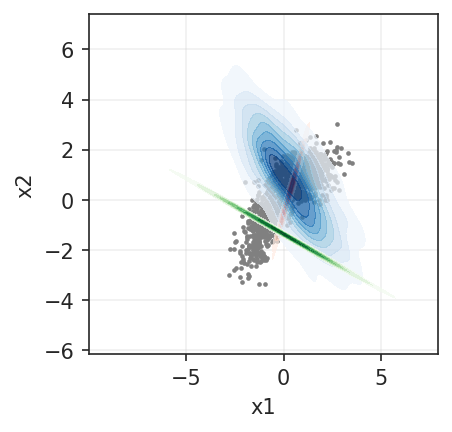

In [ ]:
import scipy.stats as stats

hist1 = stats.multivariate_normal(params["mu1"], params["sigma1"]).rvs(size=1000)
hist2 = stats.multivariate_normal(params["mu2"], params["sigma2"]).rvs(size=1000)
hist3 = stats.multivariate_normal(params["mu3"], params["sigma3"]).rvs(size=1000)

fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
sns.scatterplot(x="x1", y="x2", data=df, s=5, linewidth=0, ax=ax, color="grey")
sns.kdeplot(x=hist1[:, 0], y=hist1[:, 1], ax=ax, cmap="Reds", fill=True, alpha=0.7)
sns.kdeplot(x=hist2[:, 0], y=hist2[:, 1], ax=ax, cmap="Blues", fill=True, alpha=0.7)
sns.kdeplot(x=hist3[:, 0], y=hist3[:, 1], ax=ax, cmap="Greens", fill=True, alpha=0.7)
ax.grid(alpha=0.3)

## Шаг 2: E-шаг алгоритма

На E-шаге мы будем для каждой точки считать вероятности принадлежности каждой из точек к тому или иному кластеру.

Например, $b_{i}$ — вероятность отнесения точки ко кластеру №2. Рассчитывается данная вероятность следующим образом:
$$
b_i = P(b | x_i) = \frac{P(x_i|b)P(b)}{P(x_i|a)P(a) + P(x_i|b)P(b)} = \frac{(\mathrm{Likelihood\;of\;x_i\;from\;b} )*(\mathrm{Prior\;probability\;of\;b})}{\mathrm{Total\;probability\;of\;x_i}} = \frac{A * B}{C} = \frac{D}{C}
$$

В логарифмической форме это будет выглядеть как

$$
\log{b_i} = \log{P(b_i|x)} = \log{P(x_i|b)} + \log{P(b)} - \log{(P(x_i|a)P(a) + P(x_i|b)P(b))} = \mathrm{LogLikelihood} + \mathrm{Prior} - \mathrm{Total\;probability} = \log{A} + \log{B} - \log{C}
$$

Таким же способом рассчитываются вероятности отнесения точки к кластеру №1 и №3.

Далее рассчитывается максимальная вероятность отнесения точки в один из кластеров:

$$
\max(a_{i}, b_{i}, с_{i}) = \left\{\begin{matrix}
a_{i} \Rightarrow  \text{Кластер №1} \\ 
b_{i} \Rightarrow \text{Кластер №2} \\
c_{i} \Rightarrow \text{Кластер №3}
\end{matrix}\right. $$

In [ ]:
from scipy.special import logsumexp

X = df.values

def E_step(X, params, draw=False):
  LogLikelihood = A = np.log([
      stats.multivariate_normal(params["mu1"], params["sigma1"]).pdf(X), 
      stats.multivariate_normal(params["mu2"], params["sigma2"]).pdf(X),
      stats.multivariate_normal(params["mu3"], params["sigma3"]).pdf(X)
  ])
  logPrior = B = np.log([params["phi1"], params["phi2"], 1 - params["phi1"] - params["phi2"]])
  logPosterior = D = logPrior + LogLikelihood.T
  RealSoftMax = C = logsumexp(logPosterior, axis=1)
  probabilities = np.exp(logPosterior - np.array([RealSoftMax]).T)
  forecasts = np.argmax(probabilities, axis=1)

  if draw:
    hist1 = stats.multivariate_normal(params["mu1"], params["sigma1"]).rvs(size=1000)
    hist2 = stats.multivariate_normal(params["mu2"], params["sigma2"]).rvs(size=1000)
    hist3 = stats.multivariate_normal(params["mu3"], params["sigma3"]).rvs(size=1000)
    
    fig, axes = plt.subplots(figsize=(6, 3), dpi=150, ncols=2)
    sns.scatterplot(x=X[:, 0], y=X[:, 1], data=df, s=5, linewidth=0, ax=axes[1], hue=forecasts,
                palette={0: sns.color_palette(['#d90012'], n_colors=50)[-1],
                         1: sns.color_palette(['#0033A0'], n_colors=50)[0],
                         2: sns.color_palette(['#29AB87'])[0]})
    sns.scatterplot(x=X[:, 0], y=X[:, 1], linewidth=0, ax=axes[0], s=3, alpha=1, color="grey")
    sns.scatterplot(x=X[:, 0], y=X[:, 1], linewidth=0, ax=axes[0], s=3, alpha=1, color="grey")
    sns.kdeplot(x=hist1[:, 0], y=hist1[:, 1], ax=axes[0], cmap="Reds", fill=True, alpha=0.5)
    sns.kdeplot(x=hist2[:, 0], y=hist2[:, 1], ax=axes[0], cmap="Blues", fill=True, alpha=0.5)
    sns.kdeplot(x=hist3[:, 0], y=hist3[:, 1], ax=axes[0], cmap="Greens", fill=True, alpha=0.5)
    axes[0].grid(alpha=0.3)
    axes[1].grid(alpha=0.3)
    axes[1].legend().remove()
    axes[0].set_xlim(-4, 4)
    axes[1].set_xlim(-4, 4)
    axes[0].set_ylim(-4, 4)
    axes[1].set_ylim(-4, 4)
    plt.show()

  return RealSoftMax, probabilities

Запуск E-шага EM-алгоритма

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


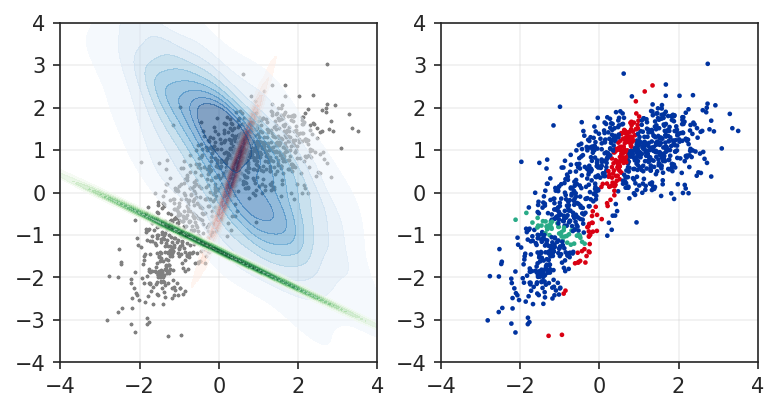

In [ ]:
total_prob, probabilities = E_step(X, params, draw=True)

## Шаг 3: M-шаг алгоритма

Переинициализация входных параметров EM-алгоритма после E-шага.

1. Расчет новых априорных вероятностей (долей точек в каждом из кластеров от общего числа точек) $\varphi_{1}$, $\varphi_{2}$ и $\varphi_{3}$.
2. Расчет средних значений трех распределений (кластеров): $\mu_{1}$, $\mu_{2}$, $\mu_{3}$.
3. Расчет стандартных отклонений трех распределений (кластеров): $\sigma_{1}$, $\sigma_{2}$, $\sigma_{3}$.

In [ ]:
def M_step(X, params, probabilities):
  prob_1 = probabilities[:, 0]
  prob_2 = probabilities[:, 1]
  prob_3 = probabilities[:, 2]

  # Вычисление новых значений
  # Пропорция = prior
  phi1 = prob_1.sum() / len(X)
  phi2 = prob_2.sum() / len(X)
  phi3 = prob_3.sum() / len(X)
  
  # Среднее
  mu1 = prob_1.dot(X) / np.sum(prob_1)
  mu2 = prob_2.dot(X) / np.sum(prob_2)
  mu3 = prob_3.dot(X) / np.sum(prob_3)

  # Дисперсия
  sigma1 = (X - mu1).T.dot((X - mu1) * np.array([prob_1]).T) / np.sum(prob_1)
  sigma2 = (X - mu2).T.dot((X - mu2) * np.array([prob_2]).T) / np.sum(prob_2)
  sigma3 = (X - mu3).T.dot((X - mu3) * np.array([prob_3]).T) / np.sum(prob_3)
  return {
      "phi1" : phi1, "phi2" : phi2,
      "mu1" : mu1, "mu2" : mu2, "mu3" : mu3,
      "sigma1": sigma1, "sigma2": sigma2, "sigma3": sigma3
  }

## Запуск EM-алгоритма

EM-алгоритм работает до тех пор пока разность likelihood вероятностей данного этапа и предыдущего будет больше некоторого порогового значения. Другими словами, пока LogLikelihood не перестанет уменьшаться меньше, чем заранее заданное пороговое значение. В данном случае пороговое значение равно $\frac{1}{1000000}$.

In [ ]:
def run_EM(X, params, draw=False):
    import imageio
    avg_allprob = []

    while True:
        allprob, probabilities = E_step(X, params, draw=draw)
        avg_allprob.append(np.mean(allprob))
        if len(avg_allprob) > 2 and abs(avg_allprob[-1] - avg_allprob[-2]) < 0.000001:
            break
        params = M_step(X, params, probabilities)
        
    loglikelihood, probabilities = E_step(X, params)
    forecasts = np.argmax(probabilities, axis=1)
    return forecasts, probabilities, avg_allprob

Полный запуск EM-алгоритма

In [ ]:
pred, prob, allprob = run_EM(X, params, draw=True)

Output hidden; open in https://colab.research.google.com to view.

## Результат работы алгоритма

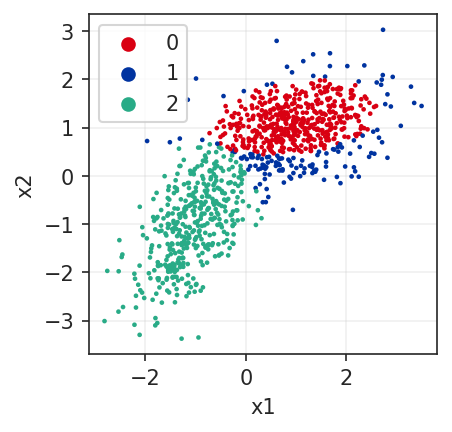

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
sns.scatterplot(x="x1", y="x2", data=df, s=5, linewidth=0, ax=ax, hue=pred,
                palette={0: sns.color_palette(['#d90012'], n_colors=50)[-1],
                         1: sns.color_palette(['#0033A0'], n_colors=50)[0],
                         2: sns.color_palette(['#29AB87'])[0]})
ax.grid(alpha=0.3)

# Задание 2

Сделайте NextFlow пайплайн, который будет подсчитывать принимать на вход аргументом список SRA-идентификаторов эксперимента, а на выход давать подсчитанные экспрессии. Путь к индексу kallisto тоже будет подаваться на вход отдельно как аргумент.

# Решение

Скачивание SRA Toolkit, инструмента для работы c .fastq файлами

In [1]:
!wget https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/3.0.0/sratoolkit.3.0.0-ubuntu64.tar.gz
!tar -xvzf sratoolkit.3.0.0-ubuntu64.tar.gz

--2022-11-29 05:37:49--  https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/3.0.0/sratoolkit.3.0.0-ubuntu64.tar.gz
Resolving ftp-trace.ncbi.nlm.nih.gov (ftp-trace.ncbi.nlm.nih.gov)... 130.14.250.10, 130.14.250.11, 2607:f220:41e:250::10, ...
Connecting to ftp-trace.ncbi.nlm.nih.gov (ftp-trace.ncbi.nlm.nih.gov)|130.14.250.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85777118 (82M) [application/x-gzip]
Saving to: ‘sratoolkit.3.0.0-ubuntu64.tar.gz’

sratoolkit.3.0.0-ub 100%[===================>]  81.80M  26.0MB/s    in 3.2s    

2022-11-29 05:37:54 (26.0 MB/s) - ‘sratoolkit.3.0.0-ubuntu64.tar.gz’ saved [85777118/85777118]

sratoolkit.3.0.0-ubuntu64/
sratoolkit.3.0.0-ubuntu64/bin/
sratoolkit.3.0.0-ubuntu64/bin/abi-dump
sratoolkit.3.0.0-ubuntu64/bin/abi-dump.3
sratoolkit.3.0.0-ubuntu64/bin/abi-load
sratoolkit.3.0.0-ubuntu64/bin/abi-load.3
sratoolkit.3.0.0-ubuntu64/bin/align-info
sratoolkit.3.0.0-ubuntu64/bin/align-info.3
sratoolkit.3.0.0-ubuntu64/bin/bam-load
sratoolk

Настройка конфигурационных файлов SRA Toolkit

In [2]:
!sratoolkit.3.0.0-ubuntu64/bin/vdb-config -i

2022-11-29T05:38:01 vdb-config.3.0.0 fatal: SIGNAL - Segmentation fault 


Скачивание и установка NextFlow

In [3]:
!curl -fsSL https://get.nextflow.io | bash

CAPSULE: Downloading dependency org.multiverse:multiverse-core:jar:0.7.0
CAPSULE: Downloading dependency org.slf4j:jul-to-slf4j:jar:1.7.36
CAPSULE: Downloading dependency org.slf4j:jcl-over-slf4j:jar:1.7.36
CAPSULE: Downloading dependency commons-io:commons-io:jar:2.11.0
CAPSULE: Downloading dependency org.codehaus.jsr166-mirror:jsr166y:jar:1.7.0
CAPSULE: Downloading dependency commons-codec:commons-codec:jar:1.15
CAPSULE: Downloading dependency com.google.guava:listenablefuture:jar:9999.0-empty-to-avoid-conflict-with-guava
CAPSULE: Downloading dependency com.beust:jcommander:jar:1.35
CAPSULE: Downloading dependency io.nextflow:nf-httpfs:jar:22.10.3
CAPSULE: Downloading dependency org.codehaus.groovy:groovy:jar:3.0.13
CAPSULE: Downloading dependency io.nextflow:nf-commons:jar:22.10.3
CAPSULE: Downloading dependency ch.grengine:grengine:jar:1.3.0
CAPSULE: Downloading dependency jline:jline:jar:2.9
CAPSULE: Downloading dependency ch.qos.logback:logback-core:jar:1.2.11
CAPSULE: Downloadin

Скачивание и распаковка FastQC

In [4]:
!wget https://www.bioinformatics.babraham.ac.uk/projects/fastqc/fastqc_v0.11.9.zip
!unzip fastqc_v0.11.9.zip
!chmod +x FastQC/fastqc

--2022-11-29 05:38:20--  https://www.bioinformatics.babraham.ac.uk/projects/fastqc/fastqc_v0.11.9.zip
Resolving www.bioinformatics.babraham.ac.uk (www.bioinformatics.babraham.ac.uk)... 149.155.133.4
Connecting to www.bioinformatics.babraham.ac.uk (www.bioinformatics.babraham.ac.uk)|149.155.133.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10249221 (9.8M) [application/zip]
Saving to: ‘fastqc_v0.11.9.zip’

fastqc_v0.11.9.zip  100%[===================>]   9.77M  3.78MB/s    in 2.6s    

2022-11-29 05:38:22 (3.78 MB/s) - ‘fastqc_v0.11.9.zip’ saved [10249221/10249221]

Archive:  fastqc_v0.11.9.zip
  inflating: FastQC/cisd-jhdf5.jar   
   creating: FastQC/Configuration/
  inflating: FastQC/Configuration/adapter_list.txt  
  inflating: FastQC/Configuration/contaminant_list.txt  
  inflating: FastQC/Configuration/limits.txt  
  inflating: FastQC/fastqc           
  inflating: FastQC/fastqc_icon.ico  
   creating: FastQC/Help/
   creating: FastQC/Help/1 Introductio

Установка MultiQC

In [5]:
!pip3 install multiqc -q
!multiqc qc

     |████████████████████████████████| 1.2 MB 17.8 MB/s 
     |████████████████████████████████| 46 kB 3.5 MB/s 
     |████████████████████████████████| 237 kB 59.0 MB/s 
     |████████████████████████████████| 130 kB 50.4 MB/s 
     |████████████████████████████████| 51 kB 6.0 MB/s 
     |████████████████████████████████| 86 kB 4.9 MB/s 
Usage: multiqc [OPTIONS] [ANALYSIS DIRECTORY]
This is MultiQC v1.13
For more help, run 'multiqc --help' or visit ]8;id=469340;http://multiqc.info\http://multiqc.info]8;;\
╭─ Error ──────────────────────────────────────────────────────────────────────╮
│ Invalid value for '[ANALYSIS DIRECTORY]': Path 'qc' does not exist.          │
╰──────────────────────────────────────────────────────────────────────────────╯


Скачивание и установка Kallisto

In [23]:
!git clone https://github.com/pachterlab/kallisto.git
!apt-get install autoconf
!cd kallisto && mkdir build && cd build && cmake .. && make

Cloning into 'kallisto'...
remote: Enumerating objects: 4136, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 4136 (delta 79), reused 117 (delta 67), pack-reused 3986
Receiving objects: 100% (4136/4136), 4.24 MiB | 4.76 MiB/s, done.
Resolving deltas: 100% (2694/2694), done.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
autoconf is already the newest version (2.69-11).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX co

# Версия №1

Аргументы пайплайна:  
- `--SRA SRRXXXX1,SRRXXXX2` — список SRR
- `--index path_to_index_file` — путь к .idx файлу

Данный NextFlow пайплайн выполняет скачивание .fastq файлов, проверку качества скачанных прочтений (FastQC и MultiQC) и рассчет экспрессии генов прочтений с помощью алгоритма Kallisto на основе заранее полученного индекс файла референс транскриптома человека.

```
params.results_dir = "/content/results"
SRA_list = params.SRA.split(",")
params.index = "/index/index.idx"

log.info ""
log.info "  Q U A L I T Y   C O N T R O L  "
log.info "================================="
log.info "SRA number         : ${SRA_list}"
log.info "Index location     : ${params.index}"
log.info "Results location   : ${params.results_dir}"

// Downloading .fastq files by the fasterq-dump tool of the sratoolkit
process DownloadFastQ {
  publishDir "${params.results_dir}"

  input:
    val sra

  output:
    path "${sra}/*"

  script:
    """
    /content/sratoolkit.3.0.0-ubuntu64/bin/fasterq-dump ${sra} -O ${sra}/
    """
}

// Creating quality control by the FastQC
process FastQC {
  publishDir "${params.results_dir}/${sra}"

  input:
    val sra
    path fastq_path

  output:
    path "fastqc/*"

  script:
    """
    mkdir fastqc
    /content/FastQC/fastqc -o fastqc $fastq_path
    """
}

// Creating quality control by the MultiQC
process MultiQC {
  publishDir "${params.results_dir}/${sra}"

  input:
    val sra
    path fastqc_data

  output:
    path "multiqc_report.html"

  script:
    """
    multiqc ${fastqc_data}
    """
}

// Kallisto quant algorithm, which quantifies abundances of transcripts
process KallistoQuant {
  publishDir "${params.results_dir}/{sra}"

  input:
    path fastq_file

  output:
    path "kallisto/*"

  script:
    """
    mkdir kallisto
    /content/kallisto/build/src/kallisto quant -i ${params.index} -o kallisto ${fastq_file}
    """
}

workflow {
  data = Channel.of( SRA_list )
  DownloadFastQ( data )
  FastQC( data, DownloadFastQ.out )
  MultiQC( data, FastQC.out.collect() )
  KallistoQuant( DownloadFastQ.out )
}
```

 Скачивание Fasta-архива с референс транскриптомом человека

In [7]:
!curl -o Homo_sapiens_GRCh38_cdna.fa.gz ftp.ensembl.org/pub/release-108/fasta/homo_sapiens/cdna/Homo_sapiens.GRCh38.cdna.all.fa.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 74.3M  100 74.3M    0     0  78.1M      0 --:--:-- --:--:-- --:--:-- 78.1M


Генерация .idx файла с помощью Kallisto Index

In [19]:
!mkdir index

mkdir: cannot create directory ‘index’: File exists
/bin/bash: ./kallisto/build/src/kallisto index -i Homo_sapiens_GRCh38_cdna.idx Homo_sapiens_GRCh38_cdna.fa.gz: No such file or directory


In [24]:
!./kallisto/build/src/kallisto index -i Homo_sapiens_GRCh38_transcriptome.idx Homo_sapiens_GRCh38_cdna.fa.gz


[build] loading fasta file Homo_sapiens_GRCh38_cdna.fa.gz
[build] k-mer length: 31
[build] warning: clipped off poly-A tail (longer than 10)
        from 1517 target sequences
[build] warning: replaced 100005 non-ACGUT characters in the input sequence
        with pseudorandom nucleotides
[build] counting k-mers ... tcmalloc: large alloc 1610612736 bytes == 0x558c919ce000 @  0x7f27b9302887 0x558c1265982d 0x558c1266140b 0x558c12623f40 0x7f27b8182c87 0x558c1262c10a
tcmalloc: large alloc 3221225472 bytes == 0x558cf19ce000 @  0x7f27b9302887 0x558c1265982d 0x558c1266140b 0x558c12623f40 0x7f27b8182c87 0x558c1262c10a
done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence classes ...  done
[build] target de Bruijn graph has 1229410 contigs and contains 116457368 k-mers 



Запуск NextFlow пайплайна

In [ ]:
!./nextflow run pipeline_with_kallisto_ver_1.nf --SRA SRR6410604 --index /content/index/Homo_sapiens_GRCh38_cdna.idx

# Версия №2

Добавлена возможность указания типа прочтений: SINGLE (одинарные) и PAIRED (парные). Для этого в команде запуска NextFlow пайплайна необходимо указать флаг `--layout SINGLE` или `--layout PAIRED`.



```
params.results_dir = "/content/results"
SRA_list = params.SRA.split(",")
params.index = "/content/results/index/index.idx"
params.layout = "SINGLE"

log.info ""
log.info "  Q U A L I T Y   C O N T R O L  "
log.info "================================="
log.info "SRA number         : ${SRA_list}"
log.info "Index location     : ${params.index}"
log.info "Layout type        : ${params.layout}"
log.info "Results location   : ${params.results_dir}"

// Downloading .fastq files by the fasterq-dump tool of the sratoolkit
process DownloadFastQ {
  publishDir "${params.results_dir}"

  input:
    val sra

  output:
    path "${sra}/*"

  script:
    """
    /content/sratoolkit.3.0.0-ubuntu64/bin/fasterq-dump ${sra} -O ${sra}/
    """
}

// Creating quality control by the FastQC
process FastQC {
  publishDir "${params.results_dir}/${sra}"

  input:
    val sra
    path fastq_path

  output:
    path "fastqc/*.html"

  script:
    """
    mkdir fastqc
    /content/FastQC/fastqc -o fastqc $fastq_path
    """
}

// Creating quality control by the MultiQC
process MultiQC {
  publishDir "${params.results_dir}/${sra}"

  input:
    val sra
    path fastqc_data

  output:
    path "multiqc_report.html"

  script:
    """
    multiqc ${fastqc_data}
    """
}

// Kallisto quant algorithm, which quantifies abundances of transcripts
process KallistoQuant {
  publishDir "${params.results_dir}/kallisto"

  input:
    val sra
    val layout_type
    path fastq_file

  output:
    path "${sra}/*"

  script:
  if( layout_type == 'SINGLE' )
    """
    mkdir ${sra}
    /content/kallisto/build/src/kallisto quant -i ${params.index} -o ${sra} --single -l 180 -s 20 ${fastq_file}
    """
  else if( layout_type == 'PAIRED' )
    """
    mkdir ${sra}
    /content/kallisto/build/src/kallisto quant -i ${params.index} -o ${sra} ${fastq_file}
    """
}

workflow {
  data = Channel.of( SRA_list )
  DownloadFastQ( data )
  FastQC( data, DownloadFastQ.out )
  MultiQC( data, FastQC.out.collect() )
  layout_type = Channel.of( params.layout )
  KallistoQuant( data, params.layout, DownloadFastQ.out )
}
```

Очистка памяти от файлов с предудущих запусков пайплайна

In [ ]:
!rm -r results
!rm -r work

Запуск NextFlow пайплайна

In [38]:
!./nextflow run my_pipeline_with_kallisto_ver_2.nf --SRA SRR6410613,SRR6410614 --layout PAIRED --index /content/index/Homo_sapiens_GRCh38_transcriptome.idx -resume

N E X T F L O W  ~  version 22.10.3
Launching `my_pipeline_with_kallisto_ver_2.nf` [sick_dubinsky] DSL2 - revision: 1fc03e8c2b

  Q U A L I T Y   C O N T R O L  
SRA number         : [SRR6410613, SRR6410614]
Index location     : /content/index/Homo_sapiens_GRCh38_transcriptome.idx
Layout type        : PAIRED
Results location   : /content/results
[-        ] process > DownloadFastQ -

[-        ] process > DownloadFastQ -
[-        ] process > KallistoQuant -

executor >  local (2)
[e2/0f6227] process > DownloadFastQ (2) [  0%] 0 of 2
[-        ] process > KallistoQuant     -

executor >  local (2)
[e2/0f6227] process > DownloadFastQ (2) [  0%] 0 of 2
[-        ] process > KallistoQuant     -

executor >  local (2)
[e2/0f6227] process > DownloadFastQ (2) [ 50%] 1 of 2
[-        ] process > KallistoQuant     -

executor >  local (3)
[e2/0f6227] process > DownloadFastQ (2) [ 50%] 1 of 2
[5b/432e44] process > KallistoQuant (1) [  0%] 0 of 1

executor >  local (4)
[94/d67eda] process > Down

In [ ]:
!rm -r /content/result/SRR6410608
!rm -r /content/result/SRR6410609

In [ ]:
!./nextflow run my_pipeline_with_kallisto_ver_2.nf --SRA SRR6410610,SRR6410615 --layout PAIRED --index /content/index/Homo_sapiens_GRCh38_transcriptome.idx

In [ ]:
!rm -r /content/result/SRR6410608
!rm -r /content/result/SRR6410609

# Версия №3

Добавлен KallistoIndex процесс, который генерирует .idx файл для алгоритма кванитификации (Kallisto Quant).

Также добавлен новый аргумент:
* `--fasta url_to_fasta_archive` — URL к fasta-архиву с референс транскриптомом человека.


```
params.results_dir = "/content/results"
SRA_list = params.SRA.split(",")
params.fasta = "ftp.ensembl.org/pub/release-108/fasta/homo_sapiens/cdna/Homo_sapiens.GRCh38.cdna.all.fa.gz"
params.layout = "SINGLE"

log.info ""
log.info "  Q U A L I T Y   C O N T R O L  "
log.info "================================="
log.info "SRA number         : ${SRA_list}"
log.info "Fasta URL          : ${params.fasta}"
log.info "Layout type        : ${params.layout}"
log.info "Results location   : ${params.results_dir}"

// Downloading .fastq files by the fasterq-dump tool of the sratoolkit
process DownloadFastQ {
  publishDir "${params.results_dir}"

  input:
    val sra

  output:
    path "${sra}/*"

  script:
    """
    /content/sratoolkit.3.0.0-ubuntu64/bin/fasterq-dump ${sra} -O ${sra}/
    """
}

// Creating quality control by the FastQC
process FastQC {
  publishDir "${params.results_dir}/${sra}"

  input:
    val sra
    path fastq_path

  output:
    path "fastqc/*.html"

  script:
    """
    mkdir fastqc
    /content/FastQC/fastqc -o fastqc $fastq_path
    """
}

// Creating quality control by the MultiQC
process MultiQC {
  publishDir "${params.results_dir}/${sra}"

  input:
    val sra
    path fastqc_data

  output:
    path "multiqc_report.html"

  script:
    """
    multiqc ${fastqc_data}
    """
}

process DownloadFastaArchive {
  output:
    path "*"
  
  script:
    """
    curl -O ${params.fasta}
    """
}

// Generating index file for kallisto quant algorithm 
process KallistoIndex {
  publishDir "${params.results_dir}"

  input:
    path fasta_archive

  output:
    path "kallisto/human_transcriptome_reference.idx"

  script:
    """
    mkdir kallisto
    /content/kallisto/build/src/kallisto index -i kallisto/human_transcriptome_reference.idx ${fasta_archive}
    """
}

// Kallisto quant algorithm, which quantifies abundances of transcripts
process KallistoQuant {
  publishDir "${params.results_dir}/kallisto"

  input:
    val sra
    val layout_type
    path index_file
    path fastq_file

  output:
    path "${sra}/*"

  script:
  if( layout_type == 'SINGLE' )
    """
    mkdir ${sra}
    /content/kallisto/build/src/kallisto quant -i ${index_file} -o ${sra} --single -l 180 -s 20 ${fastq_file}
    """
  else if( layout_type == 'PAIRED' )
    """
    mkdir ${sra}
    /content/kallisto/build/src/kallisto quant -i ${index_file} -o ${sra} ${fastq_file}
    """
}

workflow {
  data = Channel.of( SRA_list )
  DownloadFastQ( data )
  FastQC( data, DownloadFastQ.out )
  MultiQC( data, FastQC.out.collect() )
  DownloadFastaArchive()
  KallistoIndex( DownloadFastaArchive.out )
  layout_type = Channel.of( params.layout )
  KallistoQuant( data, params.layout, KallistoIndex.out, DownloadFastQ.out )
}
```

Очистка памяти от файлов с предудущих запусков пайплайна

In [ ]:
!rm -r results
!rm -r work

Запуск NextFlow пайплайна



In [ ]:
!./nextflow run pipeline_with_kallisto_ver_3.nf --SRA SRR6410603,SRR6410616 --layout PAIRED --fasta ftp.ensembl.org/pub/release-108/fasta/homo_sapiens/cdna/Homo_sapiens.GRCh38.cdna.all.fa.gz -resume

In [ ]:
!./nextflow run pipeline_with_kallisto_ver_3.nf --SRA SRR6410603,SRR6410616 --layout PAIRED --fasta ftp.ensembl.org/pub/release-108/fasta/homo_sapiens/cdna/Homo_sapiens.GRCh38.cdna.all.fa.gz -resume

In [ ]:
import pandas as pd
results = pd.read_csv("results/kallisto/SRR6410603/abundance.tsv", sep="\t", index_col=0)
results

,length,eff_length,est_counts,tpm
target_id,,,,
ENST00000631435.1,12,12.000,0.0000,0.00000
ENST00000415118.1,8,8.000,0.0000,0.00000
ENST00000448914.1,13,13.000,0.0000,0.00000
ENST00000434970.2,9,9.000,0.0000,0.00000
ENST00000632684.1,12,12.000,0.0000,0.00000
...,...,...,...,...
ENST00000514057.1,681,542.632,23935.3000,889.03300
ENST00000416718.2,547,408.716,26.4422,1.30395
ENST00000445254.1,415,276.777,16.0000,1.16513


SRR17993485 - SINGLE \\


SRR15712414 - DOUBLE

# Задание 3

Попробуйте сами написать алгоритм, который будет при помощи EM-алгоритма оценивать представленность экспрессию транскриптов (необязательно работать с графами или прочтениями, можете упростить ситуацию до модельной).